In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
line_type = {'solid line' : 'solid', ## 라인 유형
             'dashed line' : 'dashed',
             'dash-dotted line' : 'dashdot',
             'dotted line' : 'dotted'}

In [3]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [4]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [6]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [7]:
train_data.shape,test_data.shape

((210,), (60,))

In [8]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


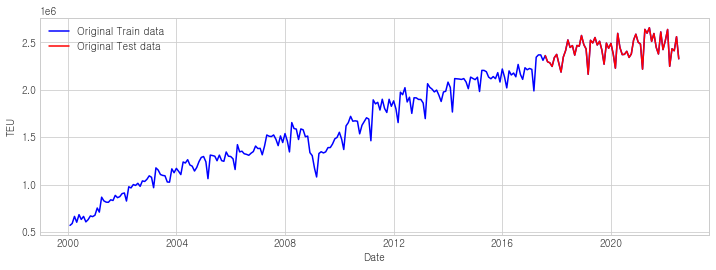

In [9]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Original Train data')
plt.plot(test_data, 'red', label='Original Test data')
plt.legend()

### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

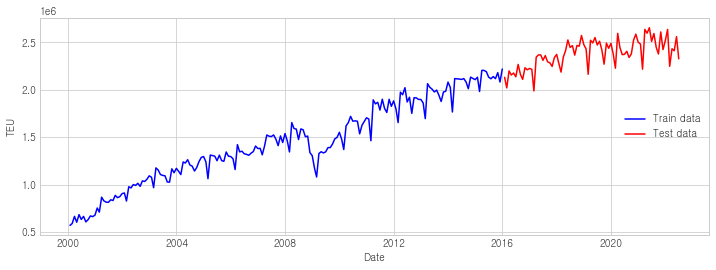

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend(loc=5)

In [17]:
len(train),len(test)

(192, 78)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((163, 18, 10), (163, 12, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_test= X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_test= Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((49, 18, 10), (49, 12, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(Conv1D(filters=48, kernel_size=2,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),padding='causal',name='extractor'))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(Flatten())
model.add(RepeatVector(12)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(66, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
16/16 [==============================] - 7s 289ms/step - loss: 0.3938 - mae: 0.5385 - val_loss: 0.5492 - val_mae: 0.6972
Epoch 2/200
16/16 [==============================] - 0s 17ms/step - loss: 0.2493 - mae: 0.4142 - val_loss: 0.3433 - val_mae: 0.5114
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.1539 - mae: 0.3121 - val_loss: 0.2843 - val_mae: 0.4698
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.1199 - mae: 0.2796 - val_loss: 0.3097 - val_mae: 0.5158
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0881 - mae: 0.2398 - val_loss: 0.2695 - val_mae: 0.4632
Epoch 6/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0819 - mae: 0.2293 - val_loss: 0.2070 - val_mae: 0.4200
Epoch 7/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0686 - mae: 0.2078 - val_loss: 0.2107 - val_mae: 0.4135
Epoch 8/200
16/16 [==============================] - 0s 18ms/step - loss: 0

In [28]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

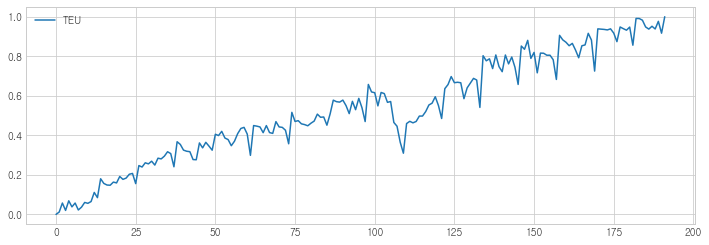

In [29]:
label_train.plot()

<AxesSubplot:>

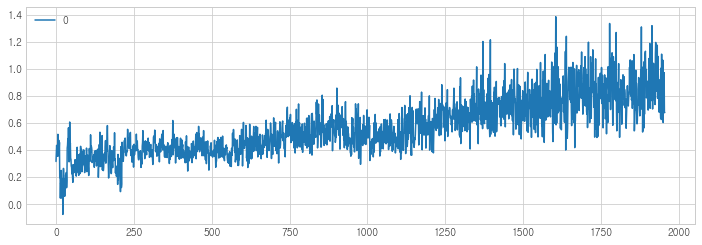

In [30]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

#### Most Probable Explanation

### 1. 2017.07 ~ 2018.06

In [31]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [32]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [33]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

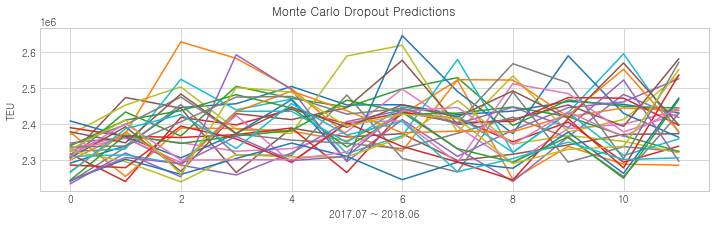

In [34]:
rcParams['figure.figsize'] = 12, 3
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2018.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [35]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [36]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [37]:
np.mean(df.std()/df.mean())

0.031062602996826172

In [37]:
#df.to_csv('CNNLSTM1.csv')

In [39]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 52186.92140907894
MAPE: 1.9888635449328922


In [39]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[:12]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2291891.0,2377597.0,2305751.75,2317747.0,2347832.0,2311901.0,2332989.25,2240577.75,2370750.5,2324334.25,2409007.0,2300228.5,2339775.0,2390196.5,2234603.75,2306809.0,2327444.25,2342488.5,2325920.0,2310456.5,2243870.75,2268450.0,2244406.5,2286888.75,2242838.0,2378750.75,2311040.25,2336677.0,2329451.5,2266009.25


In [40]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:222]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2018-06-30,2443990,1385,2.926085,2.901474,4.385095,110.3,7980.1,1092.8,137274768,103.55


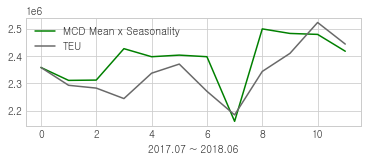

In [48]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.head(12).reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.head(12).reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend(loc=2)

Mean RMSE: 104493.74701634364
Mean MAPE: 3.600960292445586


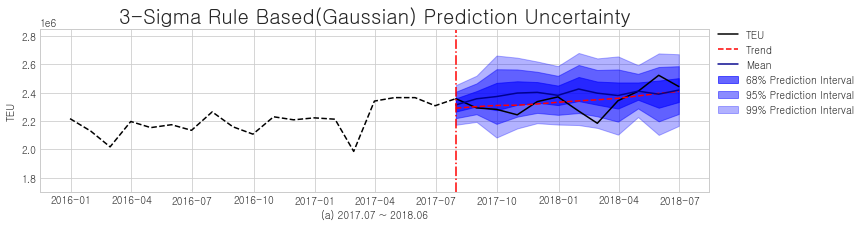

In [41]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().mean())/ test_data.head(12).reset_index()['TEU'])*100) )

In [43]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666
추세 변동에 대한 포함확률: 0.75


Median RMSE: 104898.59136648058
Median MAPE: 3.5578095201479294


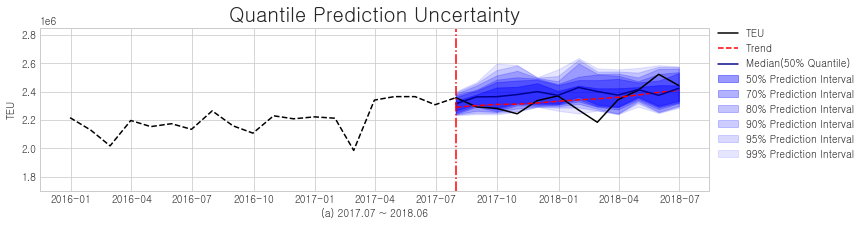

In [44]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.head(12).reset_index()['TEU'])*100) )

In [45]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 0.75


In [46]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 153503.55
Quantile 70% Interval Sharpness 158928.94687499994


RMSE: 119171.50511268587
MAPE: 4.248667908979911


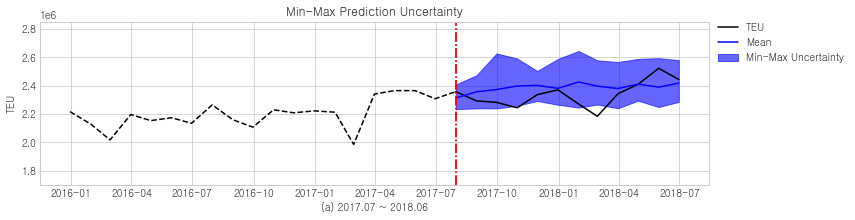

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')
plt.plot(df2.transpose().mean(),color='blue',label='Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='blue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(12).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [48]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334


In [49]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 307007.12
Quantile 95% Interval Sharpness 261910.71458333347
Min Max Interval Sharpness 302814.78


In [50]:
import CRPS.CRPS as pscore

In [51]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(12).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

27642.11527777777
41185.74333333334
45824.392222222225
107654.00305555557
40437.54722222224
16272.480555555556
113007.03916666665
167227.09916666668
26860.10138888889
14005.25138888889
89327.23833333334
24328.42861111111


In [52]:
a = np.array([27642.11527777777,
41185.74333333334,
45824.392222222225,
107654.00305555557,
40437.54722222224,
16272.480555555556,
113007.03916666665,
167227.09916666668,
26860.10138888889,
14005.25138888889,
89327.23833333334,
24328.42861111111])

In [53]:
np.mean(a)

59480.95331018519

In [38]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2387895.0

In [44]:
test_data.head(12).mean()

2338658.5833333335

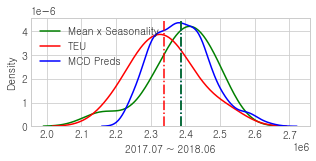

In [41]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.head(12).reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
#sns.distplot(test_data.head(12),hist=False,color='red',label='TEU')
sns.distplot(test_data.head(12),color='red',label='TEU',hist=False)
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2387895.0,color='blue',linestyle='dashdot')
plt.axvline(2387436.5239303163,color='green',linestyle='dashdot')
plt.axvline(test_data.head(12).mean(),color='red',linestyle='dashdot')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend()

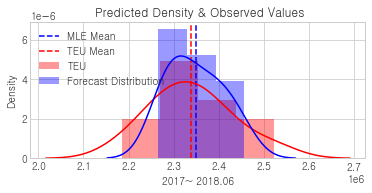

In [37]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(12).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017~ 2018.06')
plt.legend(loc=2)

In [40]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(12).reset_index()['TEU'].mean(), scale=test_data.head(12).reset_index()['TEU'].std() ) )
LL

4640.257732096623

In [43]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5370.852586331721

In [47]:
LL = -np.sum( stats.norm.logpdf(test_data.head(12).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

201.52411147033638

In [48]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [49]:
for i in range(0,30):
    print(KL(df[i],test_data.head(12).reset_index()['TEU']))

1141296.0906118061
247000.28465536563
1315454.718344441
435724.4476322961
211730.53401601157
287934.96652356617
458271.45448877465
126823.65979209224
1542593.3834437267
1078980.4235424337
1118574.1979425617
1452320.3485271344
857713.6071525684
699139.7315507195
716303.0266497589
1060700.8077386783
574860.6077582655
440771.46670404566
21281.267760807576
410194.8032068238
337948.6356205089
752919.5446559754
293720.23979155964
90451.38363117818
283848.66858899663
1149632.8572301061
375692.0291711587
1265579.330013017
729082.7127168726
148405.97549646875


In [62]:
a = np.array([1141296.0906118061,
247000.28465536563,
1315454.718344441,
435724.4476322961,
211730.53401601157,
287934.96652356617,
458271.45448877465,
126823.65979209224,
1542593.3834437267,
1078980.4235424337,
1118574.1979425617,
1452320.3485271344,
857713.6071525684,
699139.7315507195,
716303.0266497589,
1060700.8077386783,
574860.6077582655,
440771.46670404566,
21281.267760807576,
410194.8032068238,
337948.6356205089,
752919.5446559754,
293720.23979155964,
90451.38363117818,
283848.66858899663,
1149632.8572301061,
375692.0291711587,
1265579.330013017,
729082.7127168726,
148405.97549646875])

In [63]:
np.mean(a)

654165.0401652572

In [43]:
attention = pd.read_csv('Attention.csv')
lstm = pd.read_csv('LSTM.csv')
tcn = pd.read_csv('TCN.csv')

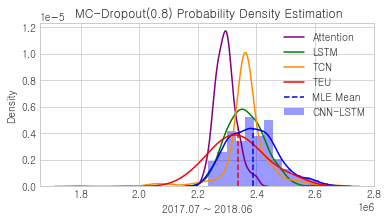

In [54]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.head(12).mean(), ymax=0.35, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.35, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend()

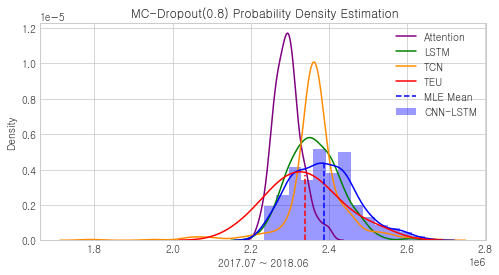

In [51]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.head(12).mean(), ymax=0.3, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.35, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend()

In [66]:
for i in range(0,30):
    print(np.linalg.norm(df[i]-test_data.head(12).reset_index()['TEU']))

RMSE: 77120.00877126641
MAPE: 2.466045830301276
RMSE: 100323.62113918719
MAPE: 3.57794236659841
RMSE: 104129.4710367619
MAPE: 3.253882845070525
RMSE: 102828.2154132713
MAPE: 3.644693289920457
RMSE: 106269.51276412723
MAPE: 3.7486062007523437


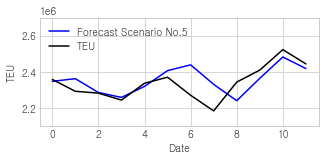

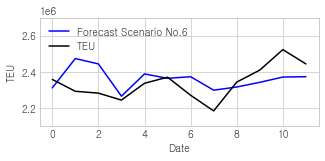

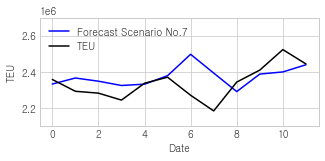

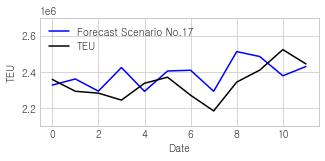

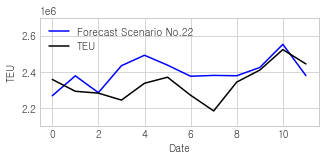

In [56]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
#plt.title('2017.07 ~ 2018.06')
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[4]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[4])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[5],label='Forecast Scenario No.6',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[5]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[5])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[6],label='Forecast Scenario No.7',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[6]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[6])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[16]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[16])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[21],label='Forecast Scenario No.22',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[21]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[21])/ test_data.head(12).reset_index()['TEU'])*100) )

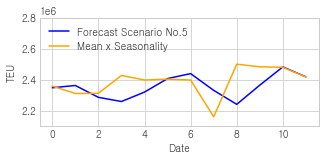

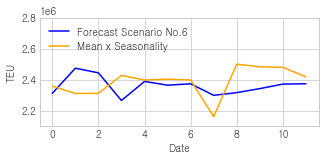

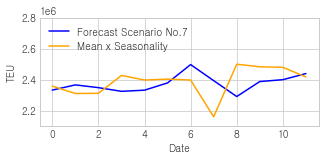

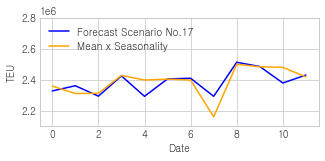

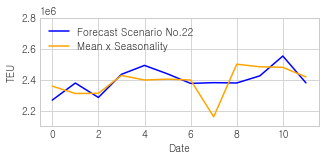

In [44]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[5],label='Forecast Scenario No.6',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[6],label='Forecast Scenario No.7',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[21],label='Forecast Scenario No.22',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

### 2. 2018.07 ~ 2019.06

In [38]:
X_test_2 = np.array(feature_test[12:30]).reshape((1, 18, 10)) 

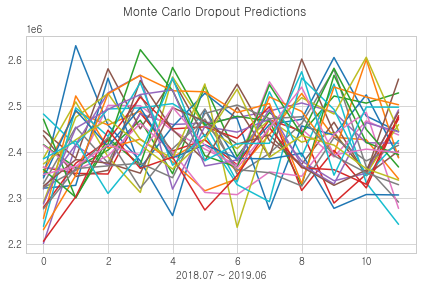

In [39]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2018.07 ~ 2019.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [40]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [41]:
np.mean(df.std()/df.mean())

0.032310113310813904

In [44]:
df.to_csv('CNNLSTM2.csv')

In [64]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2423666.2

In [84]:
(df.transpose().mean()*seasonal.iloc[12:24].reset_index()['Seasonal'].mean()).mean()

2422486.75

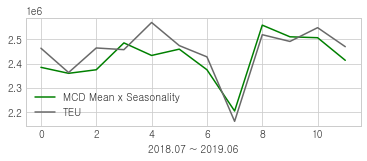

In [54]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.iloc[12:24].reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.iloc[12:24].reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2018.07 ~ 2019.06')
plt.legend()

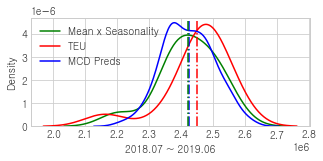

In [55]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.iloc[12:24].reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
sns.distplot(test_data.iloc[12:24],hist=False,color='red',label='TEU')
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2423666.2,color='blue',linestyle='dashdot')
plt.axvline(2422486.75,color='green',linestyle='dashdot')
plt.axvline(test_data.iloc[12:24].mean(),color='red',linestyle='dashdot')
plt.xlabel('2018.07 ~ 2019.06')
plt.legend()

In [63]:
rmse = math.sqrt(mean_squared_error(trend[12:24].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[12:24].reset_index()['TEU_Trend']- df.transpose().median())/ trend[12:24].reset_index()['TEU_Trend'])*100) )

RMSE: 36068.86404529713
MAPE: 1.088825333845177


In [64]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[12:24]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-31,2347745.25,2356157.0,2415948.0,2366788.75,2201072.25,2446165.0,2366837.5,2330873.0,2386503.0,2482462.75,2321150.75,2255396.5,2471234.75,2279538.0,2319456.0,2435489.75,2414694.5,2322027.25,2290410.0,2238236.25,2343533.5,2230911.5,2361861.0,2205673.25,2287185.0,2325575.0,2350800.25,2276257.5,2374016.25,2385014.75


In [45]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:234]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2019-06-30,2469920,1354,2.840263,2.897122,4.424881,109.8,6166.1,1175.62,140568904,100.79


Mean RMSE: 110883.73209010043
Mean MAPE: 3.468603232244116


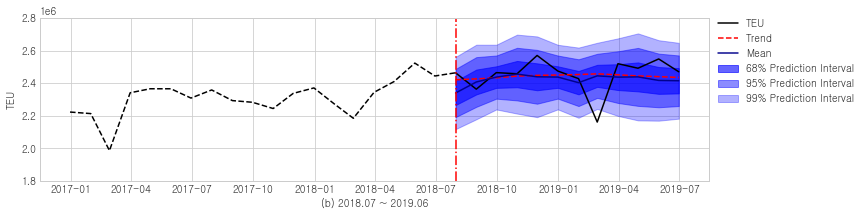

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [51]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666
추세 변동에 대한 포함확률: 0.9166666666666666


Median RMSE: 116305.22762197415
Median MAPE: 3.600102337628078


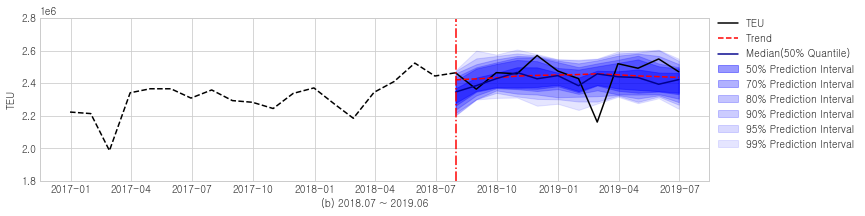

In [123]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [66]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.9166666666666666


In [52]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 152090.62
Quantile 70% Interval Sharpness 153141.5770833333


RMSE: 106406.95165069691
MAPE: 3.5604299957473047


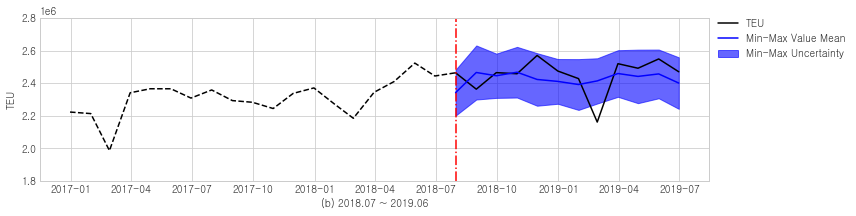

In [67]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='blue',alpha=0.6, label='Min-Max Uncertainty')

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [68]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666


In [69]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 304181.12
Quantile 95% Interval Sharpness 262338.9005208333
Min Max Interval Sharpness 300780.5


In [70]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[12:24].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

84629.10472222224
21139.779722222218
24021.414444444446
22685.816111111108
85921.33361111111
21198.634166666667
24767.271111111113
246836.31027777775
51870.02416666667
36992.034166666665
94537.04611111112
29501.702222222215


In [71]:
a = np.array([84629.10472222224,
21139.779722222218,
24021.414444444446,
22685.816111111108,
85921.33361111111,
21198.634166666667,
24767.271111111113,
246836.31027777775,
51870.02416666667,
36992.034166666665,
94537.04611111112,
29501.702222222215])

In [72]:
np.mean(a)

62008.37256944445

In [42]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2423666.2

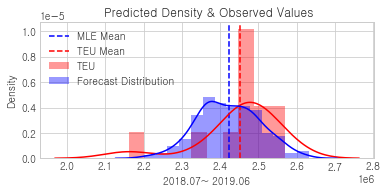

In [55]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[12:24].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[12:24].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2018.07~ 2019.06')
plt.legend(loc=2)

In [62]:
attention = pd.read_csv('Attention.csv')
lstm = pd.read_csv('LSTM.csv')
tcn = pd.read_csv('TCN.csv')

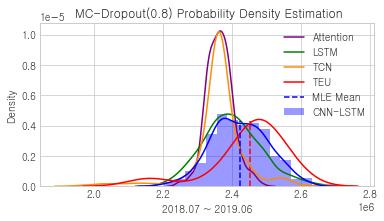

In [68]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[12:24].mean(), ymax=0.4, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[12:24].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.40, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2018.07 ~ 2019.06')
plt.legend()

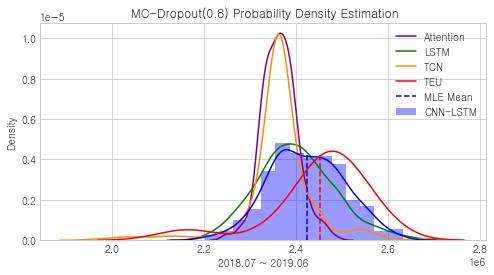

In [67]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[12:24].mean(), ymax=0.4, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[12:24].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.40, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2018.07 ~ 2019.06')
plt.legend()

In [56]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[12:24].reset_index()['TEU'].mean(), scale=test_data.iloc[12:24].reset_index()['TEU'].std() ) )
LL

4613.3804905632305

In [51]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5293.374970914098

In [57]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[12:24].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

205.70630985435926

In [58]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[12:24].reset_index()['TEU']))

61318.597256345325
243855.07178364092
49458.72015963881
577795.6930318414
177850.34195067937
38481.997125040725
118560.34668739613
348220.39968027046
199867.40943739857
120498.9683942183
283898.1722689759
309788.1257795564
106198.64806647965
406819.3967427624
270210.00566249486
8989.370750143891
819307.379740724
792963.0577963856
28937.646654090062
397524.77131833514
751904.0339589303
261265.30891083105
16422.406107952193
1022705.9050262192
218549.93082553206
570722.706221434
383736.30003849085
615454.9554264578
418074.3566926002
169650.1916224011


In [59]:
a = np.array([61318.597256345325,
243855.07178364092,
49458.72015963881,
577795.6930318414,
177850.34195067937,
38481.997125040725,
118560.34668739613,
348220.39968027046,
199867.40943739857,
120498.9683942183,
283898.1722689759,
309788.1257795564,
106198.64806647965,
406819.3967427624,
270210.00566249486,
8989.370750143891,
819307.379740724,
792963.0577963856,
28937.646654090062,
397524.77131833514,
751904.0339589303,
261265.30891083105,
16422.406107952193,
1022705.9050262192,
218549.93082553206,
570722.706221434,
383736.30003849085,
615454.9554264578,
418074.3566926002,
169650.1916224011])

In [60]:
np.mean(a)

326301.0071705756

RMSE: 83859.29156787353
MAPE: 3.1328322267664457
RMSE: 120157.00932189637
MAPE: 3.664298543449848
RMSE: 114400.70808288113
MAPE: 4.043182639274462
RMSE: 133372.5791877307
MAPE: 4.234999070890096
RMSE: 125707.35284466673
MAPE: 4.207126306520109


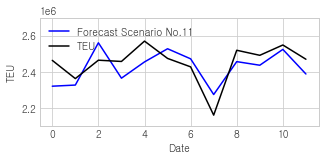

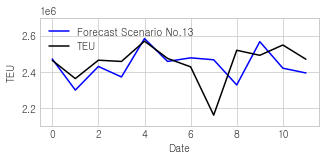

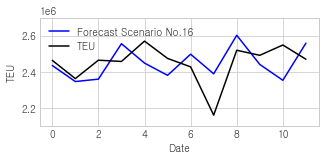

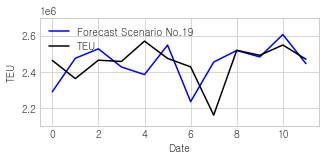

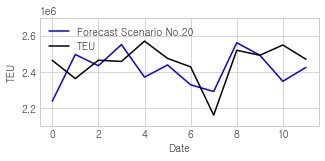

In [63]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
#plt.title('2018.07 ~ 2019.06')
plt.plot(df[10],label='Forecast Scenario No.11',color='blue')
plt.plot(test_data[12:24].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[12:24].reset_index()['TEU'], df[10]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[12:24].reset_index()['TEU']- df[10])/ test_data[12:24].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[12],label='Forecast Scenario No.13',color='blue')
plt.plot(test_data[12:24].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[12:24].reset_index()['TEU'], df[12]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[12:24].reset_index()['TEU']- df[12])/ test_data[12:24].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[15],label='Forecast Scenario No.16',color='blue')
plt.plot(test_data[12:24].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[12:24].reset_index()['TEU'], df[15]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[12:24].reset_index()['TEU']- df[15])/ test_data[12:24].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[18],label='Forecast Scenario No.19',color='blue')
plt.plot(test_data[12:24].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[12:24].reset_index()['TEU'], df[18]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[12:24].reset_index()['TEU']- df[18])/ test_data[12:24].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[19],label='Forecast Scenario No.20',color='blue')
plt.plot(test_data[12:24].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[12:24].reset_index()['TEU'], df[19]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[12:24].reset_index()['TEU']- df[19])/ test_data[12:24].reset_index()['TEU'])*100) )

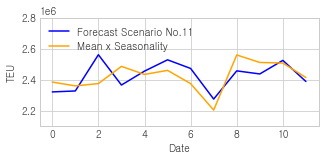

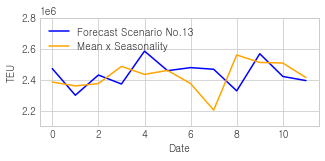

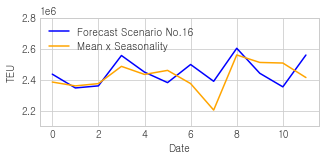

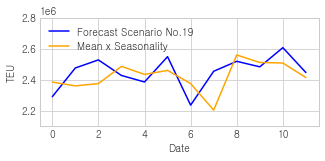

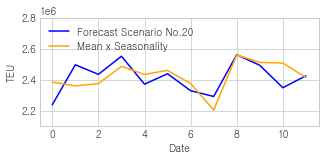

In [53]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[10],label='Forecast Scenario No.11',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[12],label='Forecast Scenario No.13',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[15],label='Forecast Scenario No.16',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[18],label='Forecast Scenario No.19',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[19],label='Forecast Scenario No.20',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

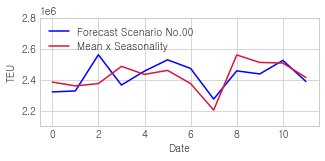

In [54]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[10],label='Forecast Scenario No.00',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='crimson',label='Mean x Seasonality')
plt.legend(loc=2)

### 3. 2019.07 ~ 2020.06

In [42]:
X_test_3 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

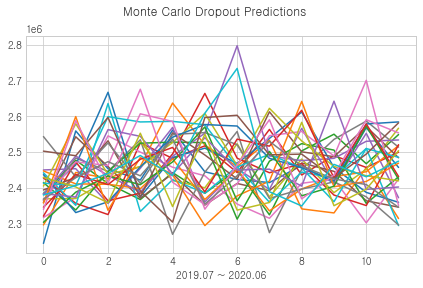

In [43]:
model_MC=  model
prediction = [model_MC.predict(X_test_3) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2020.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [44]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [45]:
np.mean(df.std()/df.mean())

0.03473127260804176

In [49]:
df.to_csv('CNNLSTM3.csv')

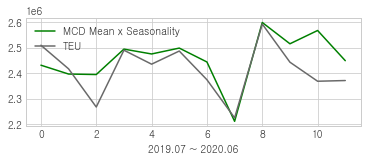

In [49]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.iloc[24:36].reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.iloc[24:36].reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2019.07 ~ 2020.06')
plt.legend(loc=2)

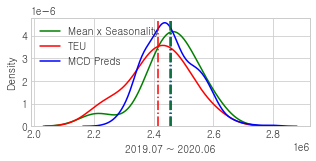

In [50]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.iloc[24:36].reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
sns.distplot(test_data.iloc[24:36],hist=False,color='red',label='TEU')
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2456558.5,color='blue',linestyle='dashdot')
plt.axvline(2456367.5,color='green',linestyle='dashdot')
plt.axvline(test_data.iloc[24:36].mean(),color='red',linestyle='dashdot')
plt.xlabel('2019.07 ~ 2020.06')
plt.legend(loc=2)

In [51]:
attention = pd.read_csv('Attention.csv')
lstm = pd.read_csv('LSTM.csv')
tcn = pd.read_csv('TCN.csv')

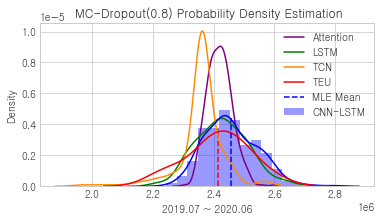

In [60]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[24:36].mean(), ymax=0.35, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[24:36].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.42, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2019.07 ~ 2020.06')
plt.legend()

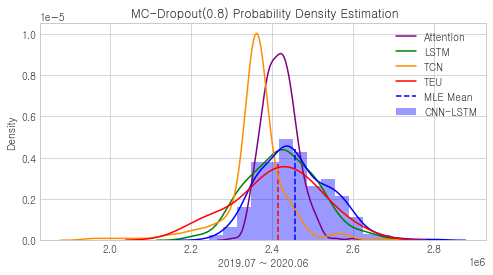

In [58]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[24:36].mean(), ymax=0.35, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[24:36].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.42, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2019.07 ~ 2020.06')
plt.legend()

In [73]:
rmse = math.sqrt(mean_squared_error(trend[24:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[24:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[24:36].reset_index()['TEU_Trend'])*100) )

RMSE: 45872.099744208535
MAPE: 1.6103369766625368


In [57]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[24:36]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2244474.75,2296142.25,2383760.5,2427771.0,2450091.25,2359239.75,2316968.75,2364542.5,2369181.0,2442106.25,2382107.75,2447366.5,2414661.75,2320810.75,2381541.0,2394073.0,2366757.25,2543553.25,2405073.75,2413175.25,2436941.75,2357474.5,2303508.25,2345674.75,2383698.75,2502771.0,2339608.25,2368124.75,2429202.5,2379941.75


In [58]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2020-06-30,2371415,1799,2.70092,2.992441,4.411836,110.4,7039.3,1210.01,116998896,95.01


Mean RMSE: 111184.99815353256
Mean MAPE: 3.7162888103221565


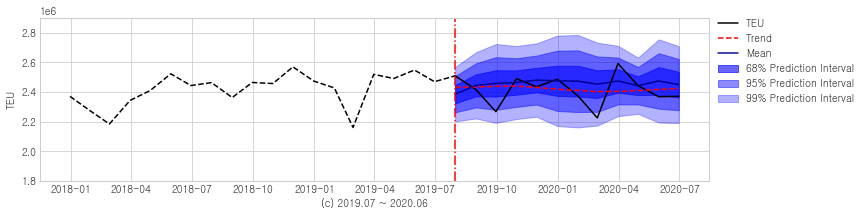

In [58]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.9e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [69]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 1.0


Median RMSE: 110010.54788145128
Median MAPE: 3.6998066831146033


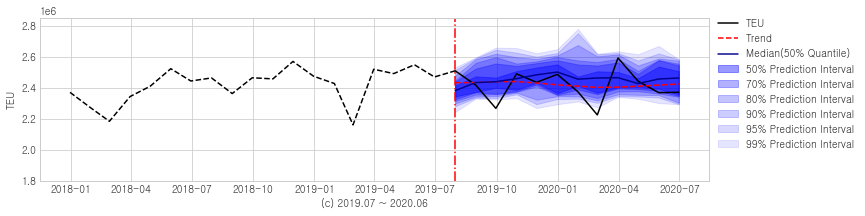

In [70]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [71]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 1.0


In [72]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 168329.08
Quantile 70% Interval Sharpness 165398.54583333325


RMSE: 124242.52884215514
MAPE: 4.173462285214146


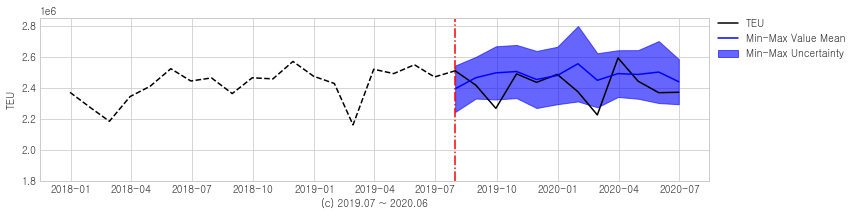

In [73]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='blue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [74]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334


In [75]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 336658.25
Quantile 95% Interval Sharpness 290089.7307291667
Min Max Interval Sharpness 343930.53


In [89]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[24:36].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

93148.28333333335
19905.030833333327
142622.15833333335
25833.729722222226
29578.367222222223
32749.508888888886
55500.15527777778
175523.48055555555
80087.61444444445
13481.978055555555
60973.39666666667
49811.14916666667


In [90]:
a = np.array([93148.28333333335,
19905.030833333327,
142622.15833333335,
25833.729722222226,
29578.367222222223,
32749.508888888886,
55500.15527777778,
175523.48055555555,
80087.61444444445,
13481.978055555555,
60973.39666666667,
49811.14916666667])

In [91]:
np.mean(a)

64934.57104166667

In [59]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2456558.5

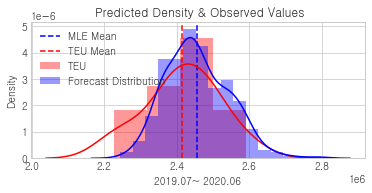

In [69]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[24:36].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[24:36].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2020.06')
plt.legend(loc=2)

In [70]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[24:36].reset_index()['TEU'].mean(), scale=test_data.iloc[24:36].reset_index()['TEU'].std() ) )
LL

4644.401767702415

In [59]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

6037.628877312653

In [71]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[24:36].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

234.69040795273554

In [72]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[24:36].reset_index()['TEU']))

495790.087208224
298056.86257797625
360676.52522298484
582418.186387951
438614.75470589916
3578.9689967144113
86183.45392796048
526843.4102708113
347673.46374666935
137151.60295985854
788452.2423831972
138748.8875195856
428035.5626973278
403644.2662925254
1141577.5101739268
944353.1143970325
889423.331405098
446979.14965544315
1020088.4664512378
1010631.0262470844
872791.3057167567
288486.97963494086
292506.2848254688
747430.7934177334
660766.9435812176
1066670.9207823821
982567.0849480357
261128.2037275586
204869.97706824585
681652.8248436649


In [73]:
a = np.array([495790.087208224,
298056.86257797625,
360676.52522298484,
582418.186387951,
438614.75470589916,
3578.9689967144113,
86183.45392796048,
526843.4102708113,
347673.46374666935,
137151.60295985854,
788452.2423831972,
138748.8875195856,
428035.5626973278,
403644.2662925254,
1141577.5101739268,
944353.1143970325,
889423.331405098,
446979.14965544315,
1020088.4664512378,
1010631.0262470844,
872791.3057167567,
288486.97963494086,
292506.2848254688,
747430.7934177334,
660766.9435812176,
1066670.9207823821,
982567.0849480357,
261128.2037275586,
204869.97706824585,
681652.8248436649])

In [74]:
np.mean(a)

551593.0730591171

RMSE: 108831.57759141627
MAPE: 4.19408353117654
RMSE: 99398.76185754278
MAPE: 3.405489937023423
RMSE: 115588.62586558762
MAPE: 4.281522669156334
RMSE: 106587.64041630542
MAPE: 3.6436627112584823
RMSE: 80017.47007935855
MAPE: 2.9124459148663977


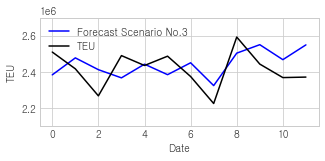

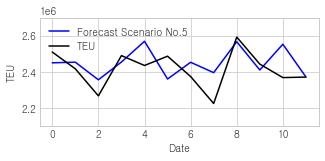

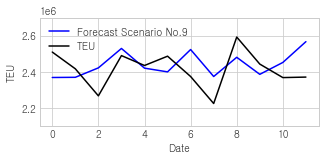

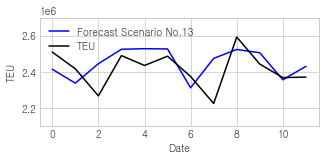

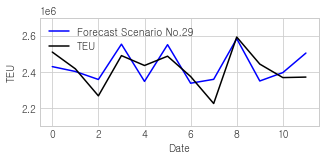

In [61]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
#plt.title('2019.07 ~ 2020.06')
plt.plot(df[2],label='Forecast Scenario No.3',color='blue')
plt.plot(test_data[24:36].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[24:36].reset_index()['TEU'], df[2]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[24:36].reset_index()['TEU']- df[2])/ test_data[24:36].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(test_data[24:36].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[24:36].reset_index()['TEU'], df[4]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[24:36].reset_index()['TEU']- df[4])/ test_data[24:36].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[8],label='Forecast Scenario No.9',color='blue')
plt.plot(test_data[24:36].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[24:36].reset_index()['TEU'], df[8]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[24:36].reset_index()['TEU']- df[8])/ test_data[24:36].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[12],label='Forecast Scenario No.13',color='blue')
plt.plot(test_data[24:36].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[24:36].reset_index()['TEU'], df[12]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[24:36].reset_index()['TEU']- df[12])/ test_data[24:36].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[28],label='Forecast Scenario No.29',color='blue')
plt.plot(test_data[24:36].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[24:36].reset_index()['TEU'], df[28]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[24:36].reset_index()['TEU']- df[28])/ test_data[24:36].reset_index()['TEU'])*100) )

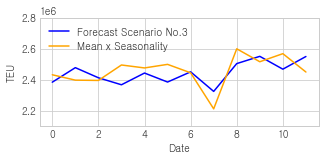

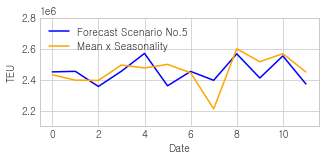

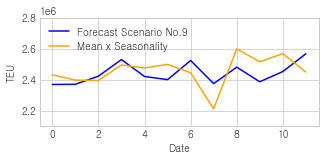

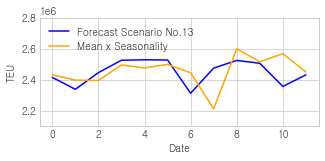

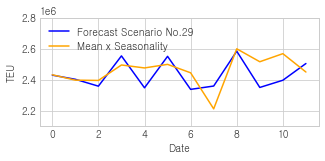

In [62]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[2],label='Forecast Scenario No.3',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[8],label='Forecast Scenario No.9',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[12],label='Forecast Scenario No.13',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[28],label='Forecast Scenario No.29',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

### 4. 2020.07 ~ 2021.06

In [46]:
X_test_4 = np.array(feature_test[36:54]).reshape((1, 18, 10)) 

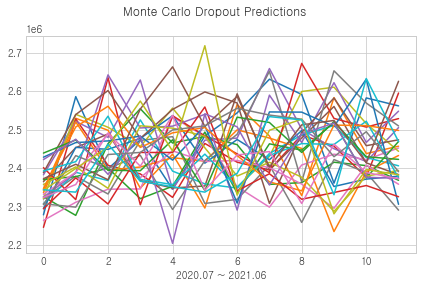

In [47]:
model_MC=  model
prediction = [model_MC.predict(X_test_4) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2020.07 ~ 2021.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [48]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [53]:
df.to_csv('CNNLSTM4.csv')

In [101]:
#attention = pd.read_csv('Attention1.csv')
#lstm = pd.read_csv('LSTM1.csv')
#tcn = pd.read_csv('TCN1.csv')

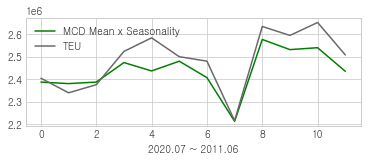

In [67]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.iloc[36:48].reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.iloc[36:48].reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2020.07 ~ 2011.06')
plt.legend(loc=2)

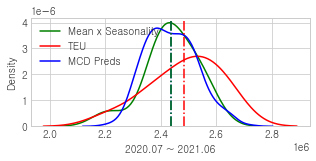

In [68]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.iloc[36:48].reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
sns.distplot(test_data.iloc[36:48],hist=False,color='red',label='TEU')
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2437714.85,color='blue',linestyle='dashdot')
plt.axvline(2437034.63788871,color='green',linestyle='dashdot')
plt.axvline(test_data.iloc[36:48].mean(),color='red',linestyle='dashdot')
plt.xlabel('2020.07 ~ 2021.06')
plt.legend(loc=2)

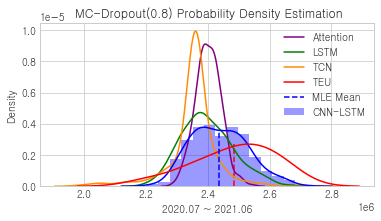

In [67]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[36:48].mean(), ymax=0.261, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.34, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2020.07 ~ 2021.06')
plt.legend()

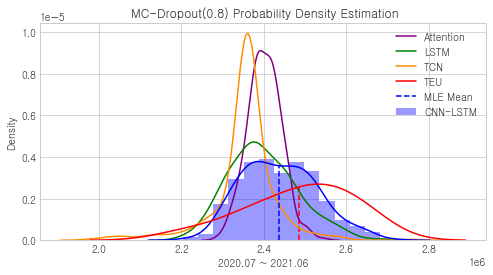

In [66]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[36:48].mean(), ymax=0.261, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.34, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2020.07 ~ 2021.06')
plt.legend()

In [68]:
np.mean(df.std()/df.mean())

0.03501665219664574

In [51]:
rmse = math.sqrt(mean_squared_error(trend[36:48].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[36:48].reset_index()['TEU_Trend']- df.transpose().median())/ trend[36:48].reset_index()['TEU_Trend'])*100) )

RMSE: 54198.35672382745
MAPE: 1.7800359422726075


In [52]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[36:48]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-31,2277972.0,2343407.5,2325263.25,2245294.5,2382414.0,2364549.25,2263285.0,2319280.75,2320307.5,2306731.75,2294426.5,2335859.25,2369963.5,2400916.5,2323859.75,2388023.25,2331438.25,2304723.25,2356769.25,2392161.5,2428176.75,2346463.25,2438893.25,2293681.25,2421938.75,2372127.0,2323449.5,2306719.5,2341973.25,2343194.25


In [76]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:258]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2021-06-30,2507761,3383,3.40973,3.569689,4.537851,117.6,8830.5,1121.3,130920264,107.4


Mean RMSE: 129697.86772953725
Mean MAPE: 4.5829390499815


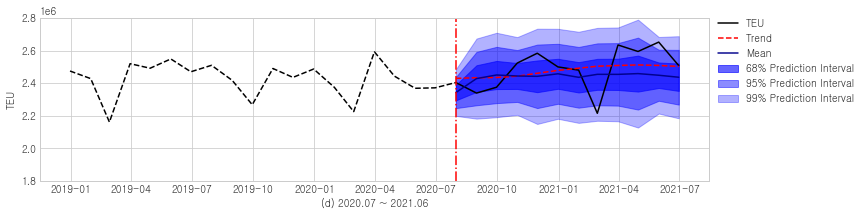

In [66]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [85]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.9166666666666666


Median RMSE: 127318.23799221149
Median MAPE: 4.43848518250675


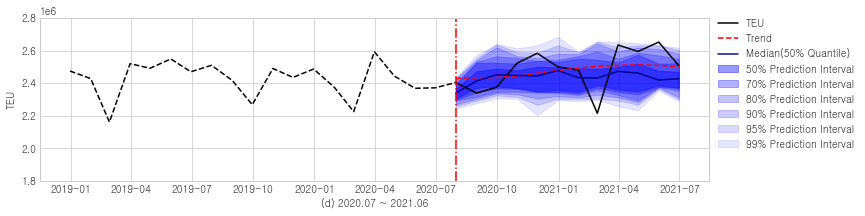

In [101]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [86]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 0.9166666666666666


In [87]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 173471.8
Quantile 70% Interval Sharpness 172031.8989583334


RMSE: 128266.00860286976
MAPE: 4.3853211587990995


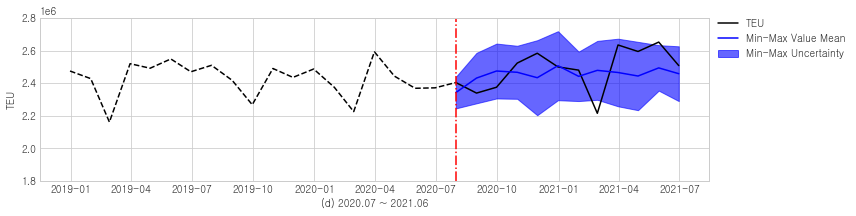

In [103]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='blue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [104]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334


In [88]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 346943.62
Quantile 95% Interval Sharpness 296268.05312500003
Min Max Interval Sharpness 346677.94


In [106]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[36:48].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

40634.12916666667
53373.21277777778
39980.31472222223
49642.50583333333
93519.93666666668
25601.120833333334
34318.81388888889
187243.14861111113
129961.18333333333
81029.36722222222
161945.65250000003
46503.10194444444


In [107]:
a = np.array([40634.12916666667,
53373.21277777778,
39980.31472222223,
49642.50583333333,
93519.93666666668,
25601.120833333334,
34318.81388888889,
187243.14861111113,
129961.18333333333,
81029.36722222222,
161945.65250000003,
46503.10194444444])

In [108]:
np.mean(a)

78646.04062500002

In [54]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2437714.8

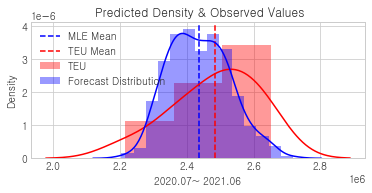

In [80]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[36:48].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2020.07~ 2021.06')
plt.legend(loc=2)

In [81]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[36:48].reset_index()['TEU'].mean(), scale=test_data.iloc[36:48].reset_index()['TEU'].std() ) )
LL

4682.49014353867

In [66]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5578.384119771394

In [82]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[36:48].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

242.1243703829936

In [83]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[36:48].reset_index()['TEU']))

105572.59889119325
427342.63417607284
824187.8504808277
668704.093357989
115779.65675814127
556764.1553945163
1119771.5340786749
1349502.0163927544
5253.376691959078
808503.6964772288
638293.4354381348
745594.5819665076
827904.8301497626
32306.738786310663
150250.57104064972
268690.2863653739
1052063.368949669
211309.5677808517
912767.8451168598
644926.9481306326
132402.68453457206
242561.0799862907
375419.8407938219
1257216.5242767902
619511.8011481215
164551.8754767856
880208.8825183756
339074.30579776835
385645.7448764064
670862.4240883209


In [84]:
a = np.array([105572.59889119325,
427342.63417607284,
824187.8504808277,
668704.093357989,
115779.65675814127,
556764.1553945163,
1119771.5340786749,
1349502.0163927544,
5253.376691959078,
808503.6964772288,
638293.4354381348,
745594.5819665076,
827904.8301497626,
32306.738786310663,
150250.57104064972,
268690.2863653739,
1052063.368949669,
211309.5677808517,
912767.8451168598,
644926.9481306326,
132402.68453457206,
242561.0799862907,
375419.8407938219,
1257216.5242767902,
619511.8011481215,
164551.8754767856,
880208.8825183756,
339074.30579776835,
385645.7448764064,
670862.4240883209])

In [101]:
np.mean(a)

551098.1649973788

RMSE: 115215.34544784678
MAPE: 3.983032734335456
RMSE: 121637.65003709531
MAPE: 3.5813954175241247
RMSE: 122443.09269520117
MAPE: 4.001650981114962
RMSE: 134441.34233857112
MAPE: 4.385726985947323
RMSE: 111926.01472201217
MAPE: 3.585891150754499


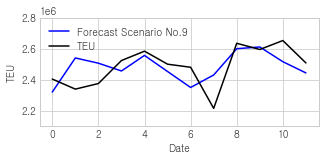

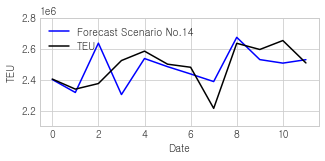

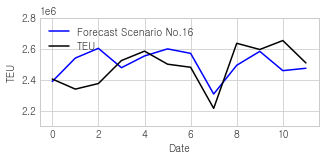

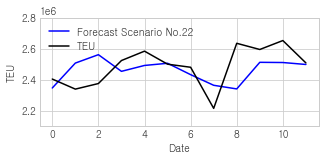

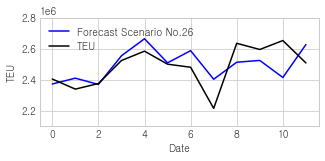

In [69]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2020.07 ~ 2021.06')
plt.plot(df[8],label='Forecast Scenario No.9',color='blue')
plt.plot(test_data[36:48].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[36:48].reset_index()['TEU'], df[8]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[36:48].reset_index()['TEU']- df[8])/ test_data[36:48].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[13],label='Forecast Scenario No.14',color='blue')
plt.plot(test_data[36:48].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[36:48].reset_index()['TEU'], df[13]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[36:48].reset_index()['TEU']- df[13])/ test_data[36:48].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[15],label='Forecast Scenario No.16',color='blue')
plt.plot(test_data[36:48].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[36:48].reset_index()['TEU'], df[15]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[36:48].reset_index()['TEU']- df[15])/ test_data[36:48].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[21],label='Forecast Scenario No.22',color='blue')
plt.plot(test_data[36:48].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[36:48].reset_index()['TEU'], df[21]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[36:48].reset_index()['TEU']- df[21])/ test_data[36:48].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[25],label='Forecast Scenario No.26',color='blue')
plt.plot(test_data[36:48].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[36:48].reset_index()['TEU'], df[25]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[36:48].reset_index()['TEU']- df[25])/ test_data[36:48].reset_index()['TEU'])*100) )

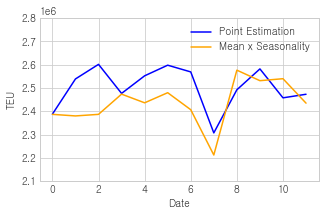

In [70]:
plt.figure(figsize=(5,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[15],label='Point Estimation',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend()

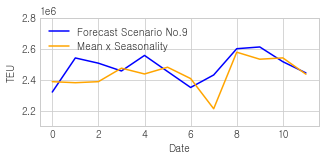

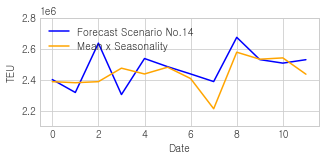

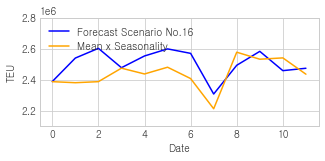

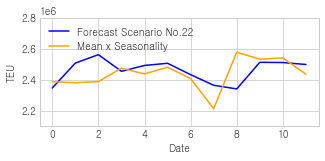

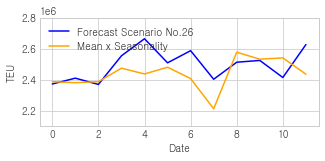

In [71]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[8],label='Forecast Scenario No.9',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[13],label='Forecast Scenario No.14',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[15],label='Forecast Scenario No.16',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[21],label='Forecast Scenario No.22',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[25],label='Forecast Scenario No.26',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

### 5. 2021.07 ~ 2022.06

In [49]:
X_test_5 = np.array(feature_test[48:66]).reshape((1, 18, 10)) 

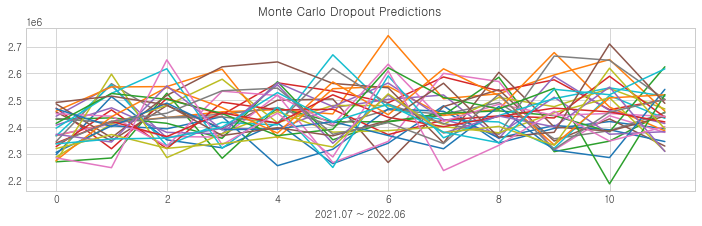

In [50]:
model_MC=  model
prediction = [model_MC.predict(X_test_5) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 12, 3
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2021.07 ~ 2022.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [51]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [58]:
df.to_csv('CNNLSTM5.csv')

In [57]:
np.mean(df.std()/df.mean())

0.036265868693590164

In [56]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2440705.2

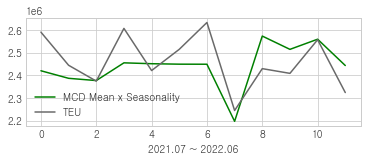

In [57]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.iloc[48:60].reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.iloc[48:60].reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2021.07 ~ 2022.06')
plt.legend()

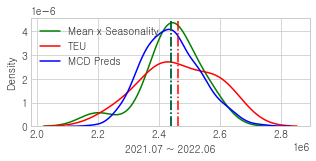

In [75]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.iloc[48:60].reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
sns.distplot(test_data.iloc[48:60],hist=False,color='red',label='TEU')
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2440705.2,color='blue',linestyle='dashdot')
plt.axvline(2440384.4607475973,color='green',linestyle='dashdot')
plt.axvline(test_data.iloc[48:60].mean(),color='red',linestyle='dashdot')
plt.xlabel('2021.07 ~ 2022.06')
plt.legend(loc=2)

In [74]:
attention = pd.read_csv('Attention2.csv')
lstm = pd.read_csv('LSTM2.csv')
tcn = pd.read_csv('TCN2.csv')

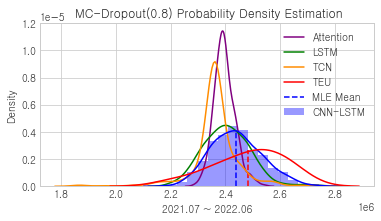

In [80]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[36:48].mean(), ymax=0.22, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.34, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2021.07 ~ 2022.06')
plt.legend()

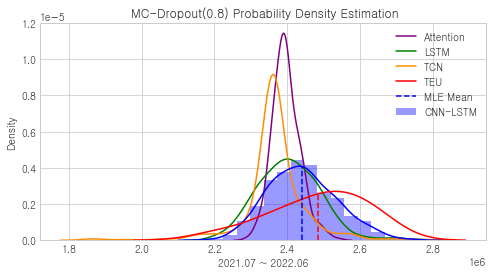

In [79]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.iloc[36:48].mean(), ymax=0.22, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.34, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2021.07 ~ 2022.06')
plt.legend()

In [71]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[48:60]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-31,2296786.5,2367004.5,2269644.25,2470131.5,2439882.75,2455777.25,2369529.25,2345723.75,2287729.75,2366451.5,2305045.25,2459149.5,2428265.5,2326471.5,2406781.75,2486046.25,2449406.75,2431417.25,2272256.25,2395219.5,2467498.0,2274638.5,2413308.75,2339748.5,2372538.5,2491342.75,2284317.25,2336928.75,2319038.75,2336740.75


In [90]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2022-06-30,2324505,2240,3.749211,3.625297,4.488265,120.1,5609.8,1277.35,118631016,132.61


In [87]:
rmse = math.sqrt(mean_squared_error(trend.tail(12).reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(12).reset_index()['TEU_Trend']- df.transpose().median())/ trend.tail(12).reset_index()['TEU_Trend'])*100) )

RMSE: 74704.76696395947
MAPE: 2.726087607984429


Mean RMSE: 121682.19447908059
Mean MAPE: 4.066736466726772


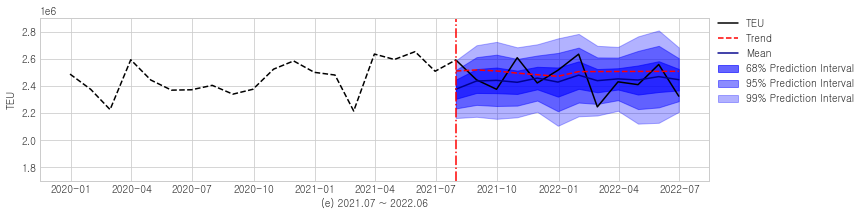

In [109]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(12).reset_index()['TEU'])*100) )

In [103]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 0.9166666666666666


Median RMSE: 124708.23368397463
Median MAPE: 4.180367007785829


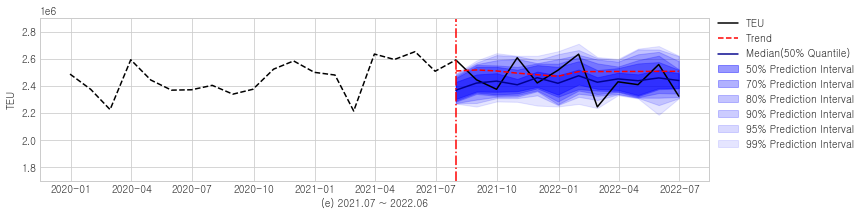

In [110]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.tail(12).reset_index()['TEU'])*100) )

In [105]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.9166666666666666


In [107]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 182151.25
Quantile 70% Interval Sharpness 185795.92604166653


RMSE: 119383.94463758168
MAPE: 4.2153977401427385


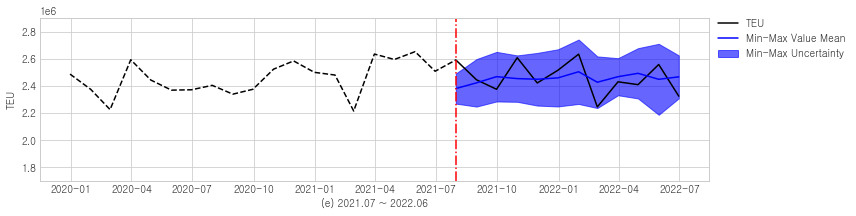

In [106]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='blue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.tail(12).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [120]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666


In [121]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 364302.66
Quantile 95% Interval Sharpness 312675.4822916666
Min Max Interval Sharpness 368416.9


In [122]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[48:60].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

175387.08055555559
22935.219444444447
37737.36833333335
136059.04
24728.735277777778
54443.69277777778
105902.21944444446
147055.09277777773
23925.499444444446
28765.258333333328
56049.74777777777
79614.27555555556


In [123]:
a = np.array([175387.08055555559,
22935.219444444447,
37737.36833333335,
136059.04,
24728.735277777778,
54443.69277777778,
105902.21944444446,
147055.09277777773,
23925.499444444446,
28765.258333333328,
56049.74777777777,
79614.27555555556])

In [71]:
np.mean(a)

74383.60247685185

In [73]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2440705.2

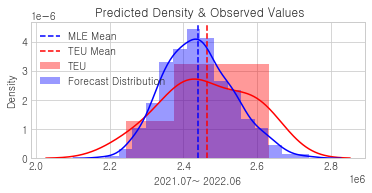

In [92]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[48:60].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[48:60].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2021.07~ 2022.06')
plt.legend(loc=2)

In [93]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[48:60].reset_index()['TEU'].mean(), scale=test_data.iloc[48:60].reset_index()['TEU'].std() ) )
LL

4656.937865434944

In [72]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

6360.637264208607

In [94]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[48:60].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

255.9214607408133

In [95]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[48:60].reset_index()['TEU']))

945446.4947146894
554728.3011094744
653081.0496268071
501363.05342070176
56163.28516864733
423404.1833555582
523261.8335480246
244878.7735324228
22468.979924050247
180978.5815186806
960071.5957765401
558197.0418511247
150713.5785135047
286329.978832955
211493.36636165885
388947.481126533
16363.91815122588
331367.8062468427
690270.3620354653
49423.04413642097
633985.1295717654
141262.05814662515
19590.244294148113
388038.9855333703
361789.75921561953
53960.56930680148
834912.0582029953
297109.1984321921
822548.8639536152
215383.79837368976


In [113]:
a = np.array([945446.4947146894,
554728.3011094744,
653081.0496268071,
501363.05342070176,
56163.28516864733,
423404.1833555582,
523261.8335480246,
244878.7735324228,
22468.979924050247,
180978.5815186806,
960071.5957765401,
558197.0418511247,
150713.5785135047,
286329.978832955,
211493.36636165885,
388947.481126533,
16363.91815122588,
331367.8062468427,
690270.3620354653,
49423.04413642097,
633985.1295717654,
141262.05814662515,
19590.244294148113,
388038.9855333703,
361789.75921561953,
53960.56930680148,
834912.0582029953,
297109.1984321921,
822548.8639536152,
215383.79837368976])

In [114]:
np.mean(a)

383917.7791327383

In [79]:
rmse = math.sqrt(mean_squared_error(trend[48:60].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[48:60].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[48:60].reset_index()['TEU_Trend'])*100) )

RMSE: 66911.50573548548
MAPE: 2.427270109725975


RMSE: 125252.66009213637
MAPE: 3.848225731254539
RMSE: 126980.26548797192
MAPE: 4.262289410569661
RMSE: 129235.42060021138
MAPE: 4.32241787783379
RMSE: 94721.68375955313
MAPE: 3.273855281089556
RMSE: 120421.253221309
MAPE: 3.578546406257909


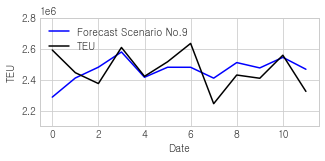

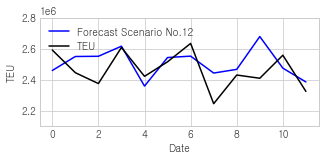

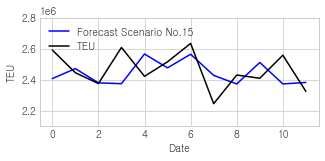

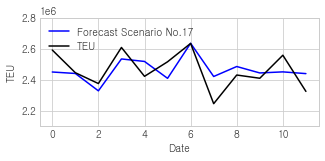

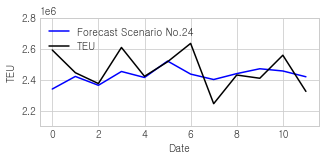

In [80]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[8],label='Forecast Scenario No.9',color='blue')
plt.plot(test_data[48:60].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[48:60].reset_index()['TEU'], df[8]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[48:60].reset_index()['TEU']- df[8])/ test_data[48:60].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[11],label='Forecast Scenario No.12',color='blue')
plt.plot(test_data[48:60].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[48:60].reset_index()['TEU'], df[11]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[48:60].reset_index()['TEU']- df[11])/ test_data[48:60].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[14],label='Forecast Scenario No.15',color='blue')
plt.plot(test_data[48:60].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[48:60].reset_index()['TEU'], df[14]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[48:60].reset_index()['TEU']- df[14])/ test_data[48:60].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(test_data[48:60].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[48:60].reset_index()['TEU'], df[16]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[48:60].reset_index()['TEU']- df[16])/ test_data[48:60].reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)

plt.plot(df[23],label='Forecast Scenario No.24',color='blue')
plt.plot(test_data[48:60].reset_index()['TEU'],label='TEU',color='black')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[48:60].reset_index()['TEU'], df[23]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[48:60].reset_index()['TEU']- df[23])/ test_data[48:60].reset_index()['TEU'])*100) )

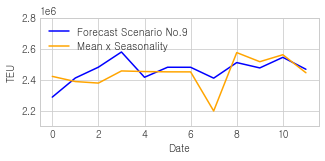

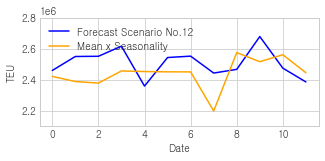

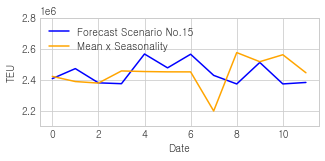

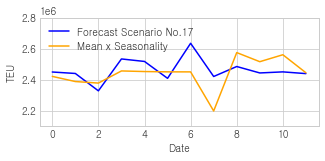

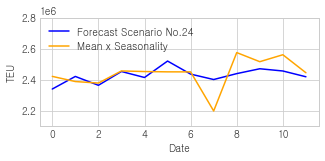

In [81]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[8],label='Forecast Scenario No.9',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[11],label='Forecast Scenario No.12',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[14],label='Forecast Scenario No.15',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[23],label='Forecast Scenario No.24',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

In [ ]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[23],label='Forecast Scenario No.24',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

### 2022.07 ~ 2023.06 예측

In [52]:
X_test_6 = np.array(feature_test.tail(18)).reshape((1, 18, 10)) 

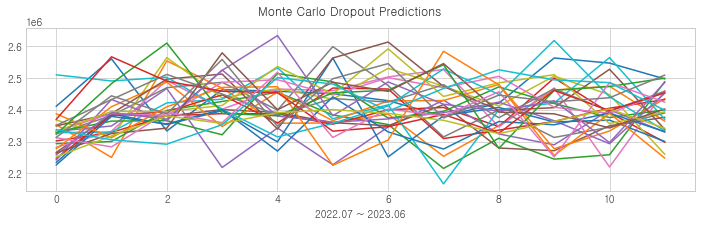

In [53]:
model_MC=  model
prediction = [model_MC.predict(X_test_6) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 12, 3
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2022.07 ~ 2023.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [54]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [55]:
np.mean(df.std()/df.mean())

0.03247656300663948

In [56]:
df2 = pd.read_csv('datetime.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-31,2411073.0,2353348.25,2293342.25,2301836.5,2332445.75,2265637.75,2281557.5,2324300.75,2368113.25,2327754.75,2233720.5,2276749.0,2329793.5,2246044.25,2241766.0,2349338.0,2332440.75,2350588.0,2332534.75,2510528.0,2225981.5,2387563.25,2323095.5,2369731.75,2257803.0,2263521.0,2311928.5,2313049.25,2251736.5,2337301.25


In [57]:
df3 = pd.read_csv('datetime.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.tail(1)

,Time
Date,
2023-06-30,1


In [58]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.tail()

(271, 1)


,TEU
Date,
2022-03-31,2429940
2022-04-30,2409140
2022-05-31,2557448
2022-06-30,2324505
2022-07-31,2324505


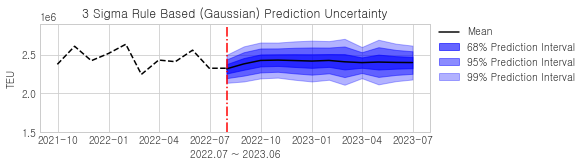

In [99]:
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('3 Sigma Rule Based (Gaussian) Prediction Uncertainty')
plt.ylim(1.5e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='black',alpha=10.0)
plt.axvline(x='2022-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")


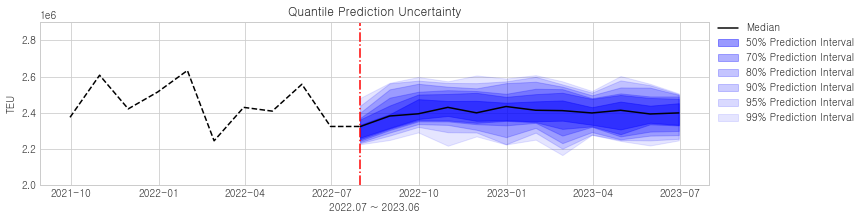

In [62]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty')
plt.ylim(2.0e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median',color='black',alpha=10.0)
plt.axvline(x='2022-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

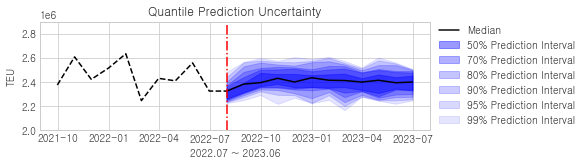

In [97]:
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=12)
plt.ylim(2.0e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median',color='black',alpha=10.0)
plt.axvline(x='2022-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [ ]:
#0,1,9,12,13

In [190]:
pd.concat([df[0],df[1],df[9],df[12],df[13]],axis=1).to_csv('1번.csv')

In [191]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,1,2,10,13,14
Date,,,,,
2022-07-31,2411073.0,2353348.2,2327754.8,2329793.5,2246044.2
2022-08-31,2560922.8,2249966.8,2330149.2,2364408.5,2382587.8
2022-09-30,2333511.8,2554530.8,2421787.2,2365891.5,2394256.8
2022-10-31,2463645.8,2468265.0,2433515.5,2321374.2,2447254.8
2022-11-30,2458661.5,2357726.5,2532897.8,2514554.0,2358547.2


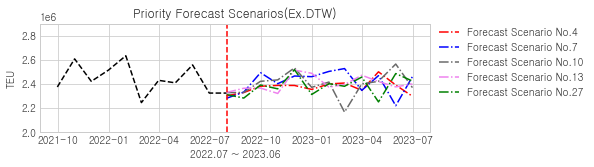

In [96]:
plt.figure(figsize=(7,2))
plt.rcParams.update({'font.size': 10})
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Priority Forecast Scenarios(Ex.DTW)')
plt.ylim(2.0e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
#plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='black',alpha=10.0)

plt.plot(df3['4'],color='red',label='Forecast Scenario No.4',linestyle='dashdot')
plt.plot(df3['7'],color='blue',label='Forecast Scenario No.7',linestyle='dashdot')
plt.plot(df3['10'],color='dimgrey',label='Forecast Scenario No.10',linestyle='dashdot')
plt.plot(df3['13'],color='violet',label='Forecast Scenario No.13',linestyle='dashdot')
plt.plot(df3['27'],color='green',label='Forecast Scenario No.27',linestyle='dashdot')
#plt.plot(df4)
plt.axvline(x='2022-07-31', color='red',linestyle='dashed')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [76]:
df4 = pd.read_csv('TEU2.csv')
df4['Date'] = pd.to_datetime(df4['Date'])
df4 = df4.set_index('Date')

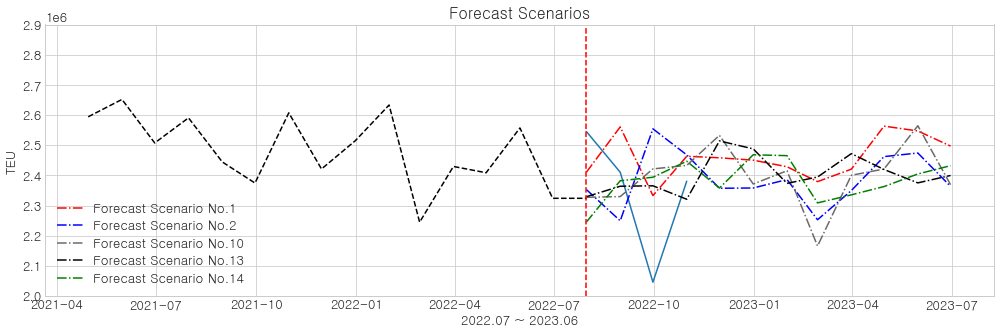

In [208]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Forecast Scenarios')
plt.ylim(2.0e6,2.9e6)
plt.plot(df4)
plt.plot(data['TEU'].iloc[255:271], 'black',linestyle='dashed')
#plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='black',alpha=10.0)

plt.plot(df3['1'],color='red',label='Forecast Scenario No.4',linestyle='dashdot')
plt.plot(df3['2'],color='blue',label='Forecast Scenario No.2',linestyle='dashdot')
plt.plot(df3['10'],color='dimgrey',label='Forecast Scenario No.10',linestyle='dashdot')
plt.plot(df3['13'],color='black',label='Forecast Scenario No.13',linestyle='dashdot')
plt.plot(df3['27'],color='green',label='Forecast Scenario No.14',linestyle='dashdot')
plt.axvline(x='2022-07-31', color='red',linestyle='dashed')
plt.legend(loc=3)

In [65]:
from dtaidistance import dtw

In [66]:
scenario = []

for i in range(0,30):
    a = dtw.distance(df[i], df.transpose().mean()*seasonal['Seasonal'].head(12).reset_index()['Seasonal'])
    scenario.append(a)

In [67]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
26,184834.266478
9,188961.970199
6,200440.120295
12,221254.697606
3,227872.614463


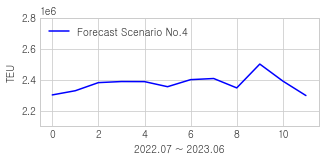

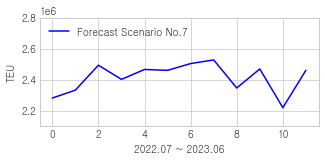

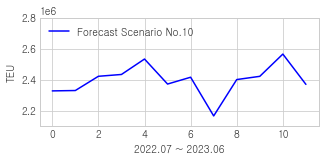

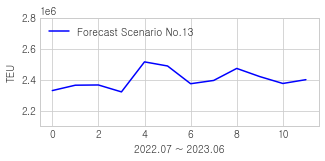

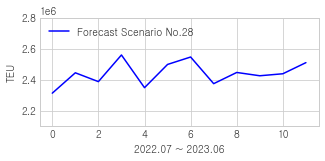

In [70]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[3],label='Forecast Scenario No.4',color='blue')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[6],label='Forecast Scenario No.7',color='blue')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[9],label='Forecast Scenario No.10',color='blue')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[12],label='Forecast Scenario No.13',color='blue')
plt.legend(loc=2)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[27],label='Forecast Scenario No.28',color='blue')
plt.legend(loc=2)

In [71]:
pd.DataFrame(scenario).sort_values(by=0).head(5)

,0
26,184834.266478
9,188961.970199
6,200440.120295
12,221254.697606
3,227872.614463


In [72]:
pd.concat([df[3],df[6],df[9],df[12],df[26]],axis=1).to_csv('1번.csv')

In [74]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,4,7,10,13,27
Date,,,,,
2022-07-31,2301836.5,2281557.5,2327754.8,2329793.5,2311928.5
2022-08-31,2328879.8,2332531.5,2330149.2,2364408.5,2283205.2
2022-09-30,2381022.2,2493176.0,2421787.2,2365891.5,2391387.5
2022-10-31,2387980.5,2401954.8,2433515.5,2321374.2,2359421.0
2022-11-30,2387460.2,2465703.2,2532897.8,2514554.0,2518683.0
